## Shell thickness

In this notebook we attempt to convert the solution suggested by Guenter Pudmich [here](https://forum.image.sc/t/how-can-i-measure-particle-size-and-shell-thickness-of-microcapsules/90473/5) for [this question](https://forum.image.sc/t/how-can-i-measure-particle-size-and-shell-thickness-of-microcapsules/90473) into python. 

The images for this question can be found on the original post and [here](https://www.dropbox.com/scl/fo/m2gvvs395l7lgazniqzxa/h?rlkey=tsb0t45frcgns31kat98ewf9f&dl=0)

In addition to numpy, matplotlib and scikit-image this example needs a few utilities from tnia-python (get code from github and install in editable mode or ```pip install tnia-python```).

## Read the data

And crop out the scale bar

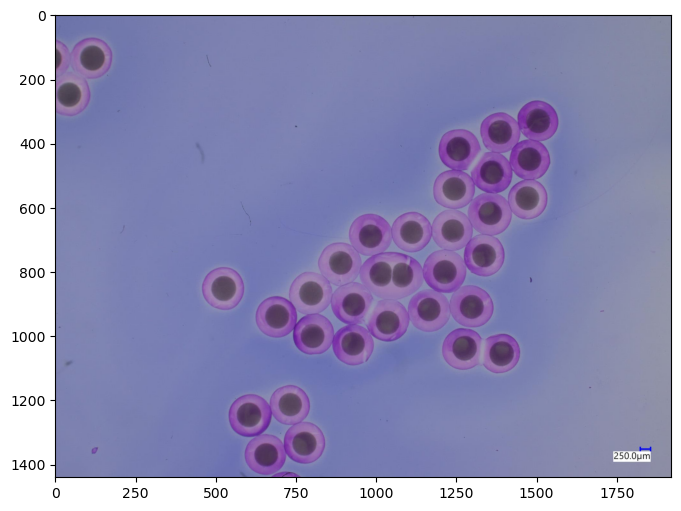

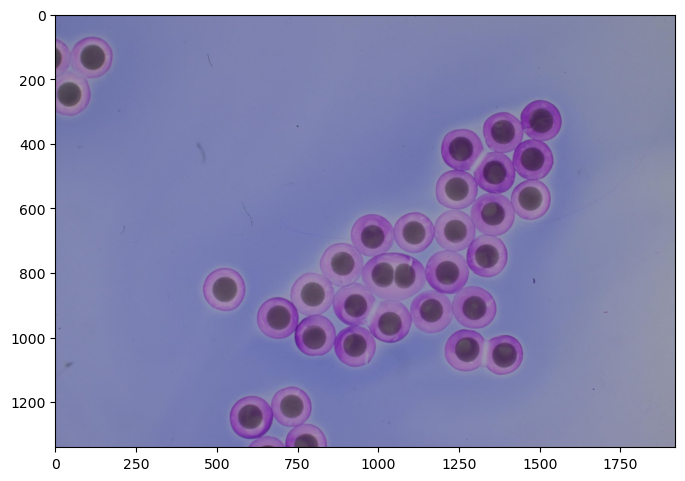

In [60]:
from skimage.io import imread
from tnia.plotting.plt_helper import imshow2d, imshow_multi2d
import os
from skimage.filters import gaussian
from skimage.color import rgb2hsv
from skimage.filters import threshold_otsu
from tnia.segmentation.separate import separate_touching
from skimage.morphology import remove_small_objects
import numpy as np

tnia_images_path = r"D:\images\tnia-python-images"

im = imread(os.path.join(tnia_images_path, r"imagesc\2024_01_05_particle_size_microcapsules\Blank 9 befor curing000000.jpg"))
            
fig = imshow2d(im)

# crop scale bar 
im = im[0:im.shape[0]-100,:,:]

fig = imshow2d(im)

## Convert to HSV color space

And show the converted channels and histograms



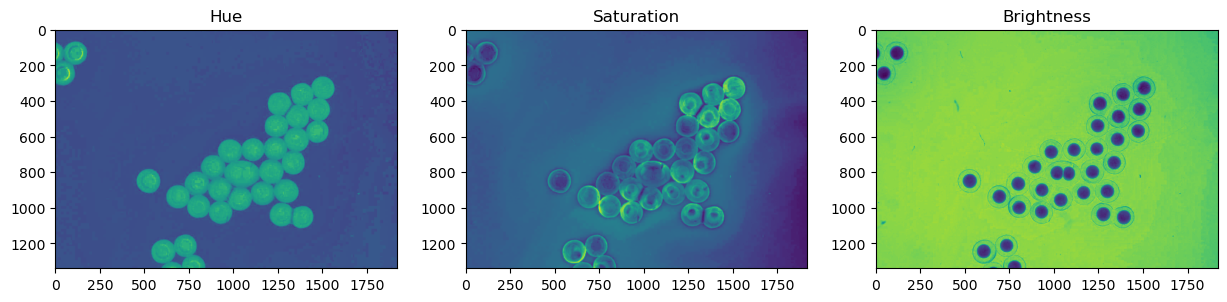

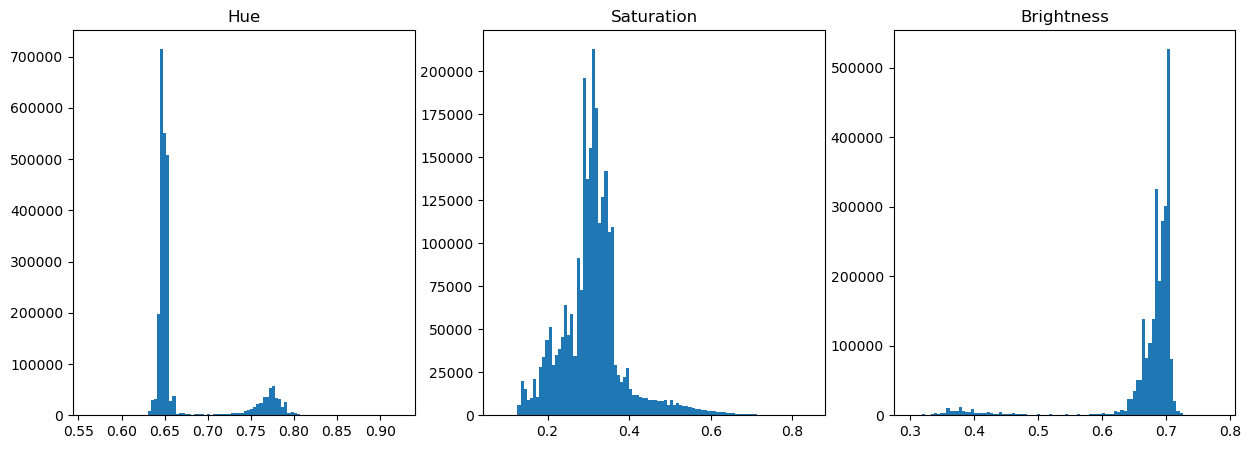

In [59]:
# convert to HSB
im_hsv = rgb2hsv(im)

fig = imshow_multi2d([im_hsv[:,:,0], im_hsv[:,:,1], im_hsv[:,:,2]], ['Hue', 'Saturation', 'Brightness'], 1, 3, width=15)

hists = []
for i in range(3):
    hists.append(np.histogram(im_hsv[:,:,i], bins=100))

fig = imshow_multi2d([im_hsv[:,:,0], im_hsv[:,:,1], im_hsv[:,:,2]], ['Hue', 'Saturation', 'Brightness'], 1, 3, width=15, height=5, plottypes=3*['hist'])



## Threshold, separate touching and label the Hue channel

We use a utility called ```separaete_touching``` which is based on [this example](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html).  This gets us the microcapsule. 

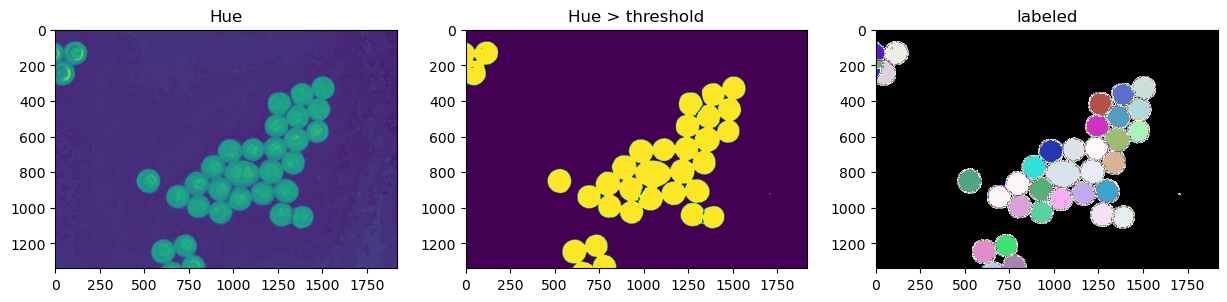

In [61]:
# apply guassian blur to hue
im_h_blur = gaussian(im_hsv[:,:,0], sigma=1)
# apply otsu threshold 
thresholded = im_h_blur>threshold_otsu(im_h_blur)
# watershed to separate then label

separated, labeled, _ = separate_touching(thresholded, 20, 1)

from skimage.measure import label
labeled = label(separated)

# import random lable colormap
from tnia.plotting.plt_helper import random_label_cmap

fig = imshow_multi2d([im_h_blur, thresholded, labeled], ['Hue', 'Hue > threshold','labeled'], 1, 3, width=15, colormaps=[None, None, random_label_cmap()])

## Threshold the v channel to get the core

We also call ```remove_small_objects```

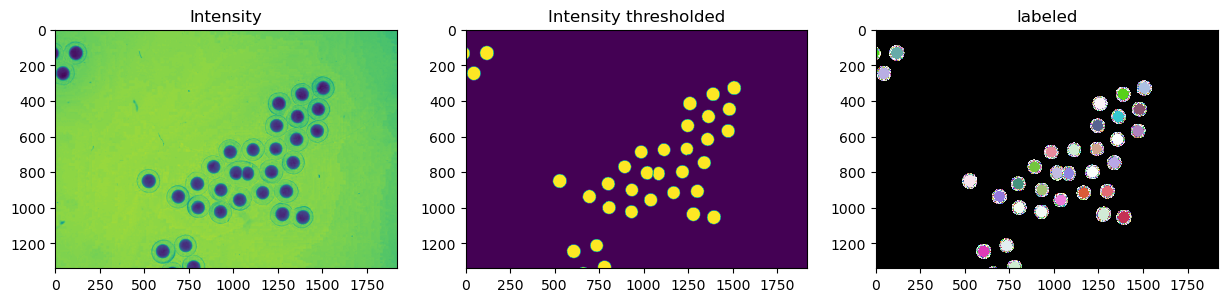

In [62]:
# import threshold min
from skimage.filters import threshold_minimum

intensity = (255*im_hsv[:,:,2]).astype(np.uint8)

thresholded_core = intensity<threshold_otsu(intensity)
# remove small objects
thresholded_core = remove_small_objects(thresholded_core, 100)
labeled_core = label(thresholded_core)

fig = imshow_multi2d([im_hsv[:,:,2], thresholded_core, labeled_core], ['Intensity', 'Intensity thresholded', 'labeled'], 1, 3, width=15, colormaps=[None, None, random_label_cmap()])

## Use conditional indexing to get the shell

If the core image is above 0 then set the corresponding pixel in the first label image to 0.

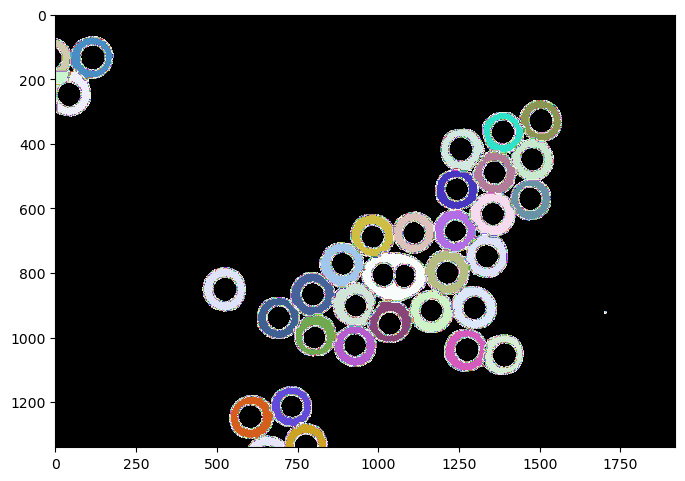

In [63]:
labeled_shell = labeled.copy()
labeled_shell[thresholded_core] = 0
fig = imshow2d(labeled_shell, colormap=random_label_cmap())

## Todo - measure the  thickness of the shell

?  